In [1]:
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage.transform import resize
import math
import numpy as np
import pandas as pd
from PIL import Image
from skimage import data, exposure
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import cv2

In [2]:
# self-written scripts
import sys
sys.path.insert(0, 'Python_Scripts')

import util
import surf_hog_analysis 

In [3]:
#!pip install seaborn

In [4]:
#!pip install imblearn

In [5]:
#!pip install scikit-learn

---

### Data preparation

In [6]:
df = pd.read_csv('data/train_complete.csv')

In [7]:
# isolate only images that have 0 or 1 defect
util.isolate_single_defects(df)

In [8]:
df.shape

(12141, 5)

---

# KNN

---

## Use initial train.csv (based on 4 imbalanced classes in train_images) in KNN

In [9]:
# eliminate class 0 in dataframe
df2 = df.query('ClassId != 0')

In [10]:
df.groupby('ClassId')['ImageId'].count()

ClassId
0    5902
1     769
2     195
3    4759
4     516
Name: ImageId, dtype: int64

In [11]:
df.head()

,FilePath,ImageId,ClassId,EncodedPixels,Defect
0,/Users/danielastuermer/neuefische/CapstoneProj...,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,/Users/danielastuermer/neuefische/CapstoneProj...,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1
2,/Users/danielastuermer/neuefische/CapstoneProj...,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1
3,/Users/danielastuermer/neuefische/CapstoneProj...,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,/Users/danielastuermer/neuefische/CapstoneProj...,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1


In [12]:
initial_images =[]

IMG_SIZE = 128
for image_id in df2['ImageId']:
    image = io.imread('data/single_defect_train_images/' + image_id)
    #resize images
    image_resized=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    #The input data have to be converted from 3 dimensional format to 1 dimensional format
    image_flat = image_resized.reshape(1, 3*IMG_SIZE*IMG_SIZE)
    # Data Normalization
    # Conversion to float
    image_flat=image_flat.astype('float32')
    # Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
    image_flat = image_flat/255.0
    initial_images.append([image_id,image_flat[0]])

In [13]:
initial_images = pd.DataFrame(initial_images , columns = ['ImageId', 'flattened_images'])

In [14]:
initial_images.head()

,ImageId,flattened_images
0,0002cc93b.jpg,"[0.28627452, 0.28627452, 0.28627452, 0.2588235..."
1,0007a71bf.jpg,"[0.19607843, 0.19607843, 0.19607843, 0.1882353..."
2,000a4bcdd.jpg,"[0.1882353, 0.1882353, 0.1882353, 0.18431373, ..."
3,000f6bf48.jpg,"[0.19215687, 0.19215687, 0.19215687, 0.3098039..."
4,0014fce06.jpg,"[0.2901961, 0.2901961, 0.2901961, 0.28627452, ..."


In [15]:
split_initial_images = pd.DataFrame(initial_images['flattened_images'].tolist())
initial_images_complete = pd.concat([initial_images, split_initial_images], axis=1)
initial_images_complete.drop(['flattened_images'], axis=1, inplace=True)

In [16]:
initial_images_complete.head()

,ImageId,0,1,2,3,4,5,6,7,8,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0002cc93b.jpg,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,0.266667,0.266667,...,0.207843,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216
1,0007a71bf.jpg,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,...,0.333333,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176
2,000a4bcdd.jpg,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,0.196078,0.196078,0.196078,...,0.301961,0.309804,0.309804,0.309804,0.305882,0.305882,0.305882,0.298039,0.298039,0.298039
3,000f6bf48.jpg,0.192157,0.192157,0.192157,0.309804,0.309804,0.309804,0.156863,0.156863,0.156863,...,0.262745,0.156863,0.156863,0.156863,0.231373,0.231373,0.231373,0.196078,0.196078,0.196078
4,0014fce06.jpg,0.290196,0.290196,0.290196,0.286275,0.286275,0.286275,0.294118,0.294118,0.294118,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922


In [17]:
# add classId to dataframe
initial_images_complete = pd.merge(initial_images_complete, df[['ImageId','ClassId']], on='ImageId')

In [18]:
initial_images_complete.head()

,ImageId,0,1,2,3,4,5,6,7,8,...,49143,49144,49145,49146,49147,49148,49149,49150,49151,ClassId
0,0002cc93b.jpg,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,0.266667,0.266667,...,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216,1
1,0007a71bf.jpg,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,...,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176,3
2,000a4bcdd.jpg,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,0.196078,0.196078,0.196078,...,0.309804,0.309804,0.309804,0.305882,0.305882,0.305882,0.298039,0.298039,0.298039,1
3,000f6bf48.jpg,0.192157,0.192157,0.192157,0.309804,0.309804,0.309804,0.156863,0.156863,0.156863,...,0.156863,0.156863,0.156863,0.231373,0.231373,0.231373,0.196078,0.196078,0.196078,4
4,0014fce06.jpg,0.290196,0.290196,0.290196,0.286275,0.286275,0.286275,0.294118,0.294118,0.294118,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,3


In [19]:
#Split in X und Y
X = initial_images_complete.drop(['ClassId','ImageId'], axis =1)
y = initial_images_complete['ClassId']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state = 42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(4991, 49152), (4991,)
Test data and target sizes: 
(1248, 49152), (1248,)


In [21]:
test_accuracy = []
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_train_scaled, y_train)


y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

0.8125


[[111   5  38   0]
 [  8  25   6   0]
 [ 69  13 863   7]
 [  5   0  83  15]]


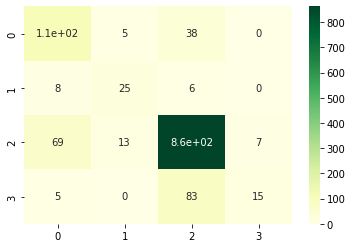

In [22]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [23]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.72      0.64       154
           2       0.58      0.64      0.61        39
           3       0.87      0.91      0.89       952
           4       0.68      0.15      0.24       103

    accuracy                           0.81      1248
   macro avg       0.68      0.60      0.59      1248
weighted avg       0.81      0.81      0.80      1248



In [27]:
proba = classifier.predict_proba(X_test_scaled)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [31]:
pb = pd.DataFrame(proba, columns = ['class 1', 'class 2', 'class 3', 'class 4'])
pb

,class 1,class 2,class 3,class 4
0,0.000000,0.0,1.000000,0.0
1,0.000000,0.0,1.000000,0.0
2,0.000000,0.0,1.000000,0.0
3,0.000000,0.0,1.000000,0.0
4,0.000000,0.0,1.000000,0.0
...,...,...,...,...
1243,0.000000,0.0,1.000000,0.0
1244,0.000000,0.0,1.000000,0.0
1245,0.333333,0.0,0.666667,0.0
1246,0.000000,0.0,1.000000,0.0


In [33]:
y_test

2794    3
2969    3
4698    3
5078    3
4132    4
       ..
2541    3
5484    3
5520    3
1729    4
5467    1
Name: ClassId, Length: 1248, dtype: int64

In [35]:
pd_complete = pd.concat([pb, y_test.reset_index()], axis=1)
pd_complete.head(20)

,class 1,class 2,class 3,class 4,index,ClassId
0,0.000000,0.0,1.000000,0.000000,2794,3
1,0.000000,0.0,1.000000,0.000000,2969,3
2,0.000000,0.0,1.000000,0.000000,4698,3
3,0.000000,0.0,1.000000,0.000000,5078,3
4,0.000000,0.0,1.000000,0.000000,4132,4
5,0.000000,0.0,1.000000,0.000000,2980,3
6,1.000000,0.0,0.000000,0.000000,4475,1
7,0.000000,0.0,0.333333,0.666667,5831,4
8,0.000000,0.0,1.000000,0.000000,6016,3
9,0.000000,0.0,1.000000,0.000000,2554,3


---

### Visualization of falsely predicted pictures

---

#### Piece-by-piece visualization

In [ ]:
# extract indices of our `hog_complete` data frame where predictions were incorrect
false_predictions = (y_pred!=y_test)
false_predictions = false_predictions[false_predictions].index.values

In [ ]:
y_pred[(y_pred!=y_test)]

In [ ]:
y_pred_false =y_pred[(y_pred!=y_test)]

predictions = pd.DataFrame(y_pred_false, index=false_predictions,columns=['ClassId_predicted'])
predictions

In [ ]:
# extract all rows from `hog_complete` where the predcition was incorrect
false_predicted_images = hog_complete.join(predictions).loc[false_predictions][['ImageId','ClassId', 'ClassId_predicted']]
# add additional information needed to find the correponding pictures
false_predicted_images = false_predicted_images.merge(df[['FilePath','ImageId']], on = 'ImageId')


In [ ]:
false_predicted_images

In [ ]:
number_images = 5

random_index = np.round(np.random.rand(number_images) * len(false_predicted_images.ImageId)) + 1
#print(random_index)

for i in range(number_images):
    #random_index = 'random_index_' + str(i+1)
    #print(random_index)
    file_path_to_image = false_predicted_images['FilePath'][random_index[i]]
    class_id = false_predicted_images['ClassId'][random_index[i]]
    image_id = false_predicted_images['ImageId'][random_index[i]]
    class_id_pred = int(false_predicted_images['ClassId_predicted'][random_index[i]])
    
    img = io.imread(file_path_to_image)
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(number_images, 1, i + 1)
    plt.imshow(img)
    plt.title(f'Image ID: {image_id} | True ClassId: {class_id} | Predicted ClassId: {class_id_pred}', fontsize=16);
    plt.axis("off")